# Распространение тепла

### Условие задачи

**Дано:**
- пластина, в которой распространяется тепло от нескольких источников
  
- коэффициенты диффузии:
    -  основного материала (синий цвет) $D_0 = 1.0$
    -  включений (белый цвет) $D_1 = 10^{-2}$

- размер массива поля температур $NxN$, где $N \in [60, 120, 240, 480, 960]$

- $T_0 = 0$ - начальная температура во всем объеме пластины

- граничные условия на ребрах пластины двух видов:
    - фиксированная температура на ребрах
        - $x = 0$
        - $y = 0$
    - абсолютная теплоизоляция на ребрах
        - $x = 60$
        - $y = 60$

- в массе пластины расположены источники тепла, мощность которых меняется по периодическому закону:
    -  $\dot{q}_i = p_i \cdot (sin(\frac{2\pi}{\theta_i}t) + 1)$
    - источник 0: $p_0 = 100$, $\theta_0 = 43$
    - источник 1: $p_1 = 100$, $\theta_1 = 77$
    
- на пластине расположены 4 пробы (черные точки)
    
- $t_m = 600$ c - общее время моделирования

**Пример схемы пластины для варианта 0**

<img src="var_00.png" width=600/>


**Требуется:**
- согласно уравнению диффузии смоделировать распространение тепла в пластине на заданное время $t_m$ для каждого $N$
- шаг по времени $dt$ подобрать самостоятельно так, чтобы расчетная схема сходилась
- для каждого $N$:
    1. вывести время расчета
    
    2. сохранить в файл(ы) и использовать в пунктах 3-5:
        - температурное поле в конечный момент времени
        - замеры температуры в местах установки проб
        - **сохраненные файлы НЕ загружать в классрум**
    
    3. построить изображение матрицы коэффициентов диффузии

    4. построить цветовую карту поля температур в конечный момент времени
        - подписать оси,
        - отобразить цветовую шкалу `colorbar`,
        - отобразить пробы в виде точек и подписать их номера.

    5. на одном рисунке построить графики температур в местах установки всех четырех проб
        - подписать оси,
        - вывести легенду.

    6. используя быстрое преобразование Фурье, восстановить периоды колебаний температуры в местах установки проб
        - `np.fft.rfft`, `np.fft.rfftfreq`, `scipy.signal.find_peaks`

    7. задокументировать все функции


**Материалы:**

- [Уравнение теплопроводности](https://ru.wikipedia.org/wiki/Уравнение_теплопроводности)
- [Solving 2D heat equation numerically using python](https://levelup.gitconnected.com/solving-2d-heat-equation-numerically-using-python-3334004aa01a)
- [Diffusion Eq 2D with Source](https://www.youtube.com/watch?v=aCRYfvh_bnY)


**Правила оценивания:**

- оценка за корректно выполненный расчет для $N$, баллов из 100:
```
    N    =   60,  120, 240, 480, 960
    g(N) =    5,    5,  10,  30,  50
```
    
- штрафы $p(i)$, баллов:
    - не выведено время расчета - 20
    - не выполнено сохранение результатов в файл(ы) - 20
    - построение графиков не использует сохраненные результаты - 20
    - не построены графики температур в местах установки проб - 20
    - не построена карта поля температур - 20
    - не построена карта коэффициентов диффузии - 10
    - не посчитаны периоды колебаний - 20
    - отсутствует документация функций - 20
    - менее значимые недоработки - 10


- итоговая оценка за задание = $\sum_{k=1}^{4}{g(N_k)} - \sum_{i}{p(i)}$


**Егоров Алексей БПМ214 7 вариант**

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from numba import njit, prange
from scipy import signal
import timeit

In [89]:
D0 = 1.0 #к-ты диффузии
D1 = 1e-2
Ns = [60,120,240,480,960] #все варианты N
N = Ns[0]
p0, theta0 = 100, 43 #параметры функции нагрева
p1, theta1 = 100, 77
C = 0.1
dx = 60 / N
dt = C * dx**2 / D0 #рассчитываем приращение времени
tmax = 600
max_iter = int(tmax / dt) #
T = np.zeros((2, N, N)) #создаем массив температур

dt, max_iter

(0.1, 6000)

In [96]:
def set_diff_matrix(N):
    """set_diff_matrix(N)
        -N - натуральное число, длина стороны сетки
    возвращает матрицу коэффициентов диффузии по заданию"""
    diffusion_matrix = np.full((N, N), D0)
    diffusion_matrix[N * 1 // 6 : N * 1 // 4, N // 6 : N // 2] = D1
    diffusion_matrix[N // 4 : N  // 2, N * 5 // 12 : N // 2] = D1
    diffusion_matrix[N * 5 // 12 : N // 2, N // 6 : N // 2] = D1
    diffusion_matrix[N * 1 // 3 : N * 5 // 12, N // 6 : N // 4] = D1
    return diffusion_matrix

def set_heat_sources(N):
    """set_heat_sources(N)
        -N - натуральное число, длина стороны сетки
    возвращает координаты x, y первого нагревателя и координаты x, y второго нагревателя"""
    heat_source0_xs = [N // 3, N * 2 // 3]
    heat_source0_ys = [N // 12, N // 6]
    heat_source1_xs = [1 * N // 12, 1 * N // 6]
    heat_source1_ys = [N // 3, 2 * N // 3]
    return heat_source0_xs, heat_source0_ys, heat_source1_xs, heat_source1_ys

In [97]:
diffusion_matrix = set_diff_matrix(N)
heat_source0_xs, heat_source0_ys, heat_source1_xs, heat_source1_ys = set_heat_sources(N)

In [98]:
plt.pcolormesh(diffusion_matrix)

In [3]:
def diffuse_step(
    it: int,
    T: np.ndarray,
    dx: float,
    dt: float,
    Ds: np.ndarray
):
    """diffuse_step(it, T, dx, dt, Ds)
        -it - итерация нагрева
        -T - массив температур
        -dx - приращение длины
        -dt - приращение температуры
        -Ds - матрица коэффициентов диффузии
        функция совершает шаг диффузии тепла"""
    
    # it = 0: T[0] -> T[1]
    # it = 1: T[1] -> T[0]
    prev = it % 2 # Определяем на основе какого T (prev) вычислять новое T последнего шага (cur).
    cur  = (it + 1) % 2
    g = dt * Ds[1:-1, 1:-1] / dx**2
    
    T[cur, 1:-1, 1:-1] = T[prev, 1:-1, 1:-1] + g * ( #правило распространения тепла
        T[prev, 1:-1, 0:-2] + 
        T[prev, 1:-1, 2:  ] + 
        T[prev, 0:-2, 1:-1] + 
        T[prev, 2:,   1:-1] -
        4 * T[prev, 1:-1, 1:-1]
    )

    
def bound_cond(T: np.ndarray):
    """bound_cond(T)
        -T - массив температур
        функция выполняет условия диффузии на границах"""
    T[:, 0, :] = 0 #фикс. температура
    T[:, -1, :] = T[:, -2, :] # абсолютная теплоизоляция
    T[:, :, 0] = 0
    T[:, :, -1] = T[:, :, -2]    
    

@njit(fastmath = True)
def q(p, theta, t):
    """q(p, theta, t)
        -p, theta - коэффициенты в функции нагрева
        -t - текцщее время
        функция рассчитвает мощность иточника нагрева в момент времени t"""
    return p*(np.sin((2 * np.pi / theta) * t) + 1)
    

def heat(T, heat_source0_xs, heat_source0_ys, q, dt, t, p, theta):
    """heat(T, heat_source0_xs, heat_source0_ys, q, dt, t, p, theta)
        -T - массив температур
        -heat_source0_xs - координаты источника по x
        -heat_source0_ys - координаты источника по y
        -q функция изменения мощности источника
        -t - текцщее время
        -dt - приращение времени
        -p, theta - коэффициенты в функции нагрева
        функция производит нагрев источника в момент времени t"""
    T[:, heat_source0_xs[0] : heat_source0_xs[1], heat_source0_ys[0] : heat_source0_ys[1]] += q(p, theta, t) * dt

In [ ]:
@njit(parallel = True)
def diffuse_step_paral(
    it: int,
    T: np.ndarray,
    d: float,
    dt: float,
    Dij: np.ndarray,
    N: int
):
    """diffuse_step_paral(it, T, dx, dt, Ds, N)
    -it - итерация нагрева
    -T - массив температур
    -dx - приращение длины
    -dt - приращение температуры
    -Ds - матрица коэффициентов диффузии
    -N - размер поля
    функция (распараллеленная) совершает шаг диффузии тепла"""

    prev = it % 2 #Определяем на основе какого T (prev) вычислять новое T последнего шага (cur).
    cur  = (it + 1) % 2
    
    for i in prange(1, N - 1):
        for j in range(1, N - 1):
            g = dt * Dij[i, j] / dx**2
            T[cur, i, j] = T[prev, i, j] + g * (
                T[prev, i+1, j] +
                T[prev, i-1, j] +
                T[prev, i, j+1] +
                T[prev, i, j-1] -
                4 * T[prev, i, j]
    )

Из-за характерного принципа работы prange, вызов альгоритма с функцией diffuse_step_paral в цикле с переменной N корректно выполняется для первого шага, но некорректно выполняется для остальных случаев.

**Как один из выриантов решения**, можно менять N, выполнять алгоритм ниже (резульат сохраняется в файл), перезагружать ядро и для другого N запускать его заново.

In [8]:
D0 = 1.0
D1 = 1e-2
Ns = [60,120,240,480,960]
N = Ns[0]
p0, theta0 = 100, 43
p1, theta1 = 100, 77
C = 0.1
dx = 60 / N
dt = C * dx**2 / D0
tmax = 600
max_iter = int(tmax / dt)
T = np.zeros((2, N, N))
diffusion_matrix = set_diff_matrix(N)
heat_source0_xs, heat_source0_ys, heat_source1_xs, heat_source1_ys = set_heat_sources(N)

res0 = []
res1 = []
res2 = []
res3 = []
t = 0
for it in trange(max_iter):
    t += dt
    heat(T, heat_source0_xs, heat_source0_ys, q, dt, t, p1, theta1)
    heat(T,heat_source1_xs, heat_source1_ys, q, dt, t, p0, theta0)
    bound_cond(T)
    diffuse_step_paral(it, T, dx, dt, diffusion_matrix, N)
    res0.append(T[0, N // 3, N // 3])
    res1.append(T[0, N // 3, N * 2 // 3])
    res2.append(T[0, N * 2 // 3, N * 2 // 3])
    res3.append(T[0, N * 2 // 3, N  // 3])
np.save('probe0_N_' + str(N), res0)
np.save('probe1_N_' + str(N), res1)
np.save('probe2_N_' + str(N), res2)
np.save('probe3_N_' + str(N), res3)
np.save('T_N_' + str(N), T[0])

100%|██████████| 6000/6000 [00:00<00:00, 20901.36it/s]


Как мы видим, альгоритм работает корректно, ниже представлены  график температур источников и цветовая карта температур для N = 60

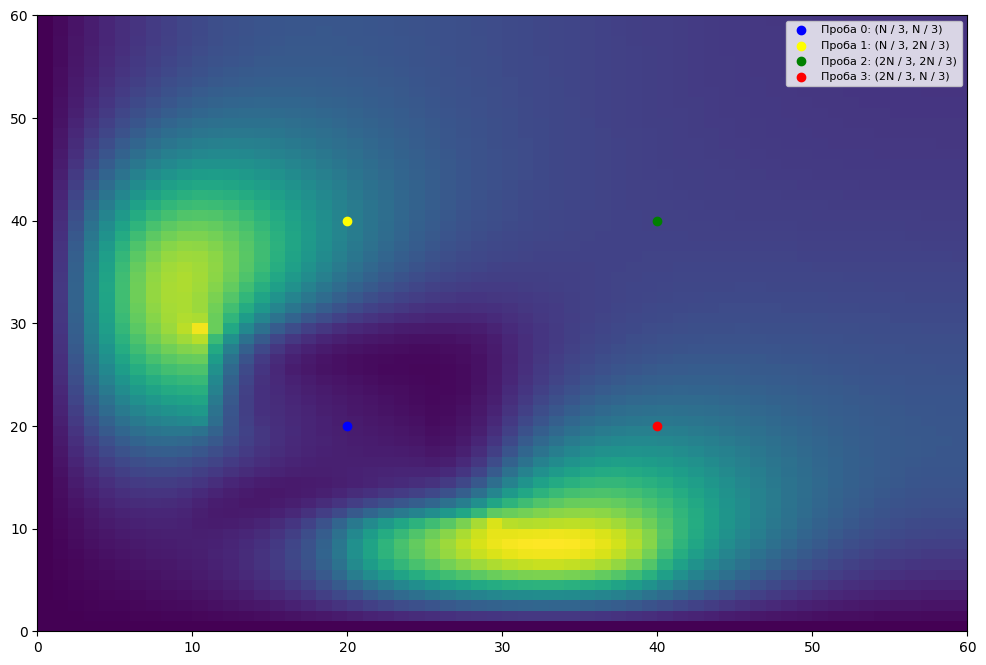

In [9]:
res0_file = np.load('probe0_N_60.npy')
res1_file = np.load('probe1_N_60.npy')
res2_file = np.load('probe2_N_60.npy')
res3_file = np.load('probe3_N_60.npy')
Tf = np.load('T_N_60.npy')

plt.figure(figsize=(12,8))
plt.pcolormesh(Tf)
plt.scatter(x= N // 3, y= N // 3, label='Проба 0: (N / 3, N / 3)', color='blue')
plt.scatter(x= N // 3, y= N * 2 // 3, label='Проба 1: (N / 3, 2N / 3)', color='yellow')
plt.scatter(x= N * 2 // 3, y= N * 2 // 3, label='Проба 2: (2N / 3, 2N / 3)', color='green')
plt.scatter(x= N * 2 // 3, y= N // 3, label='Проба 3: (2N / 3, N / 3)', color='red')
plt.legend(prop={'size': 8})


plt.figure(figsize=(12,8))
plt.plot(np.arange(max_iter)*dt, res0_file)
plt.plot(np.arange(max_iter)*dt, res1_file)
plt.plot(np.arange(max_iter)*dt, res2_file)
plt.plot(np.arange(max_iter)*dt, res3_file)
plt.legend(['Проба 0: (N / 3, N / 3)', 'Проба 1: (N / 3, 2N / 3)',
            'Проба 2: (2N / 3, 2N / 3)', 'Проба 3: (2N / 3, N / 3)'], prop={'size': 8})

 При попытке запустить алгорит с другим N, не перезагружая ядро, данные становятся неверными. Это видно на графиках ниже

In [101]:
D0 = 1.0
D1 = 1e-2
Ns = [60, 120,240,480, 960]
N = Ns[3]
p0, theta0 = 100, 43
p1, theta1 = 100, 77
C = 0.2
dx = 60 / N
dt = C * dx**2 / D0
tmax = 600
max_iter = int(tmax / dt)
T = np.zeros((2, N, N))
diffusion_matrix = set_diff_matrix(N)
heat_source0_xs, heat_source0_ys, heat_source1_xs, heat_source1_ys = set_heat_sources(N)

res0 = []
res1 = []
res2 = []
res3 = []
t = 0
for it in trange(max_iter):
    t += dt
    heat(T, heat_source0_xs, heat_source0_ys, q, dt, t, p1, theta1)
    heat(T,heat_source1_xs, heat_source1_ys, q, dt, t, p0, theta0)
    bound_cond(T)
    diffuse_step_paral(it, T, dx, dt, diffusion_matrix, N)
    res0.append(T[0, N // 3, N // 3])
    res1.append(T[0, N // 3, N * 2 // 3])
    res2.append(T[0, N * 2 // 3, N * 2 // 3])
    res3.append(T[0, N * 2 // 3, N  // 3])
np.save('prange_probe0_N_' + str(N), res0)
np.save('prange_probe1_N_' + str(N), res1)
np.save('prange_probe2_N_' + str(N), res2)
np.save('prange_probe3_N_' + str(N), res3)
np.save('prange_T_N_' + str(N), T[0])

100%|██████████| 192000/192000 [00:30<00:00, 6249.39it/s]


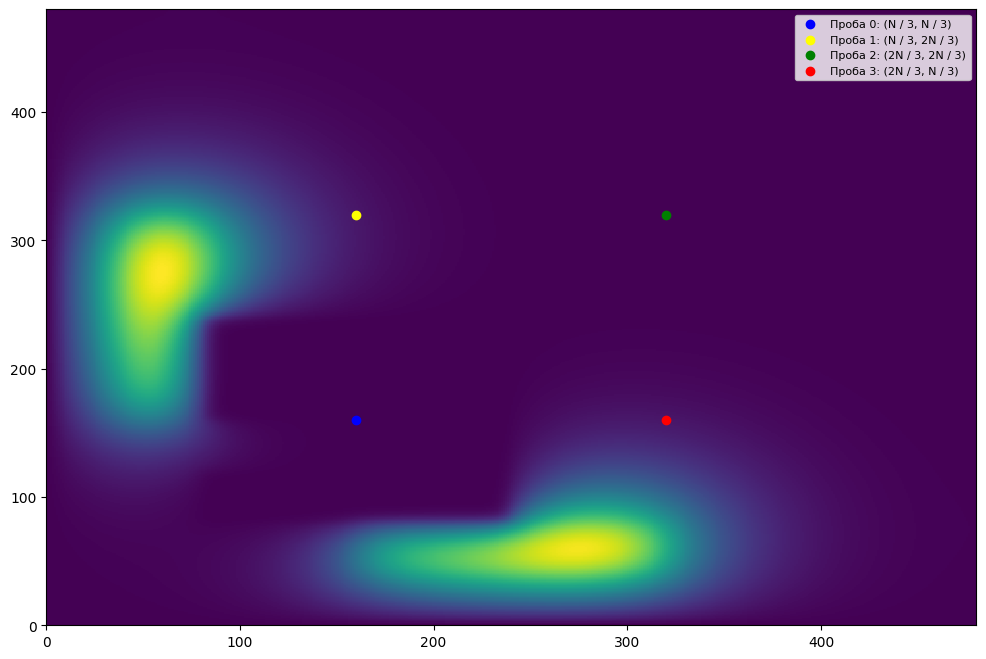

In [95]:
res0_file = np.load('prange_probe0_N_480.npy')
res1_file = np.load('prange_probe1_N_480.npy')
res2_file = np.load('prange_probe2_N_480.npy')
res3_file = np.load('prange_probe3_N_480.npy')
Tf = np.load('prange_T_N_480.npy')

plt.figure(figsize=(12,8))
plt.pcolormesh(Tf)
plt.scatter(x= N // 3, y= N // 3, label='Проба 0: (N / 3, N / 3)', color='blue')
plt.scatter(x= N // 3, y= N * 2 // 3, label='Проба 1: (N / 3, 2N / 3)', color='yellow')
plt.scatter(x= N * 2 // 3, y= N * 2 // 3, label='Проба 2: (2N / 3, 2N / 3)', color='green')
plt.scatter(x= N * 2 // 3, y= N // 3, label='Проба 3: (2N / 3, N / 3)', color='red')
plt.legend(prop={'size': 8})


plt.figure(figsize=(12,8))
plt.plot(np.arange(max_iter)*dt, res0_file)
plt.plot(np.arange(max_iter)*dt, res1_file)
plt.plot(np.arange(max_iter)*dt, res2_file)
plt.plot(np.arange(max_iter)*dt, res3_file)
plt.legend(['Проба 0: (N / 3, N / 3)', 'Проба 1: (N / 3, 2N / 3)',
            'Проба 2: (2N / 3, 2N / 3)', 'Проба 3: (2N / 3, N / 3)'], prop={'size': 8})

**Есть второе решение проблемы:** запустить цикл с нераспараллеленной функцией, тогда этой ошибки не возникает и в файлы записывается корректная информация о температуре, это видно по графикам ниже. Единственый минус этого решения, это то, что оно является очень долгим.
**Время выполнения для каждого N можно посмотреть в выводе trange ниже**

In [11]:


D0 = 1.0 #объявляем константы
D1 = 1e-2
C = 0.2
tmax = 600
p0, theta0 = 100, 43
p1, theta1 = 100, 77

for N in [60, 120, 240, 480, 960]:    
    T = np.zeros((2, N, N))
    res1 = []
    res2 = []
    res3 = []
    res0 = []
    
    t = 0
    dx = 60 / N
    dt = C * dx**2 / D0
    max_iter = int(tmax / dt)
    
    diffusion_matrix = set_diff_matrix(N)
    heat_source0_xs, heat_source0_ys, heat_source1_xs, heat_source1_ys = set_heat_sources(N)
    
    it = 0
    for it in trange(max_iter):
        t += dt
        heat(T, heat_source0_xs, heat_source0_ys, q, dt, t, p1, theta1) #нагрев источника 1
        heat(T,heat_source1_xs, heat_source1_ys, q, dt, t, p0, theta0) #нагрев источника 2
        bound_cond(T)
#         diffuse_step_paral(it, T, dx, dt, diffusion_matrix, N)
        diffuse_step(it, T, dx, dt, diffusion_matrix) #шаг диффузии
        res0.append(T[0, N // 3, N // 3]) #запись результатов
        res1.append(T[0, N // 3, N * 2 // 3])
        res2.append(T[0, N * 2 // 3, N * 2 // 3])
        res3.append(T[0, N * 2 // 3, N  // 3])
    np.save('probe0_N_' + str(N), res0) #сохранение результатов в файлы
    np.save('probe1_N_' + str(N), res1)
    np.save('probe2_N_' + str(N), res2)
    np.save('probe3_N_' + str(N), res3)
    np.save('T_fin_N_' + str(N), T[0])

100%|██████████| 768000/768000 [5:05:41<00:00, 41.87it/s]   


Понятно, что первый способ бы посчитал задачу быстрее, но я протестировал и второй.
Несмотря на его долгое выполнение, мне он кажется более корректным в рамках текущего задания.

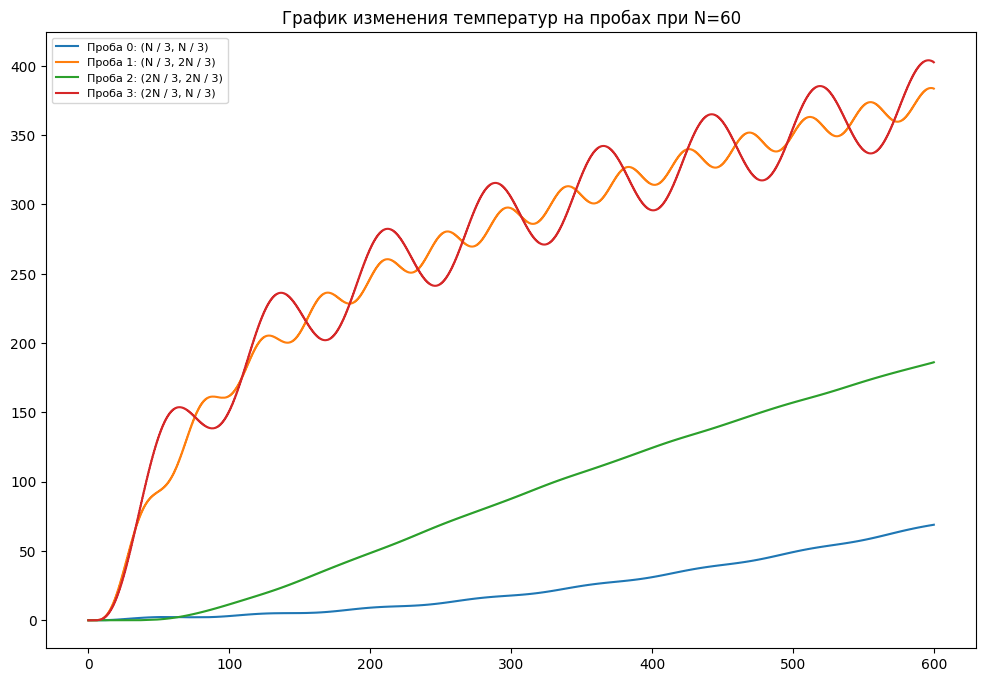

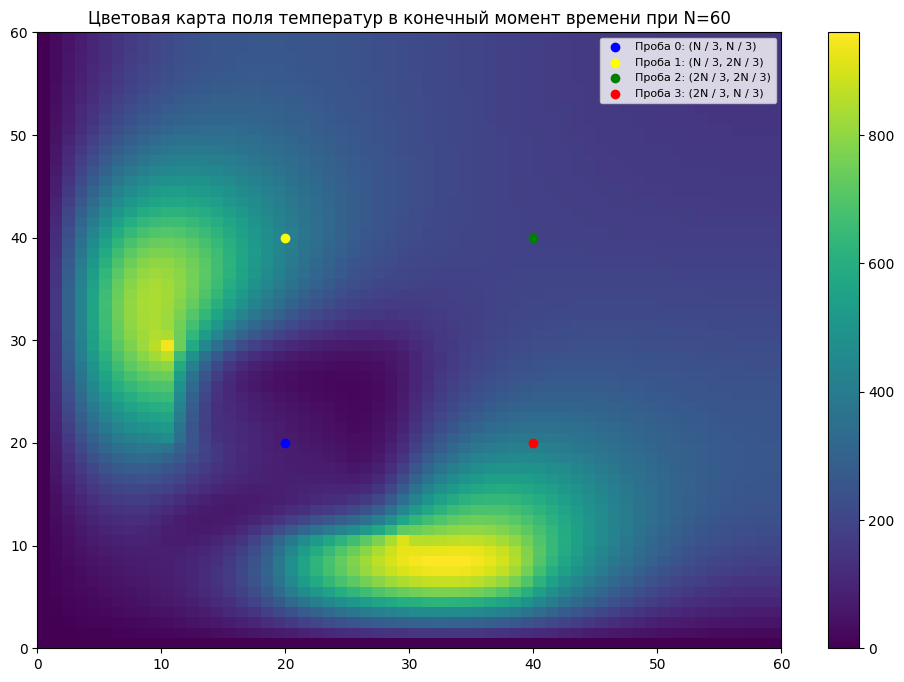

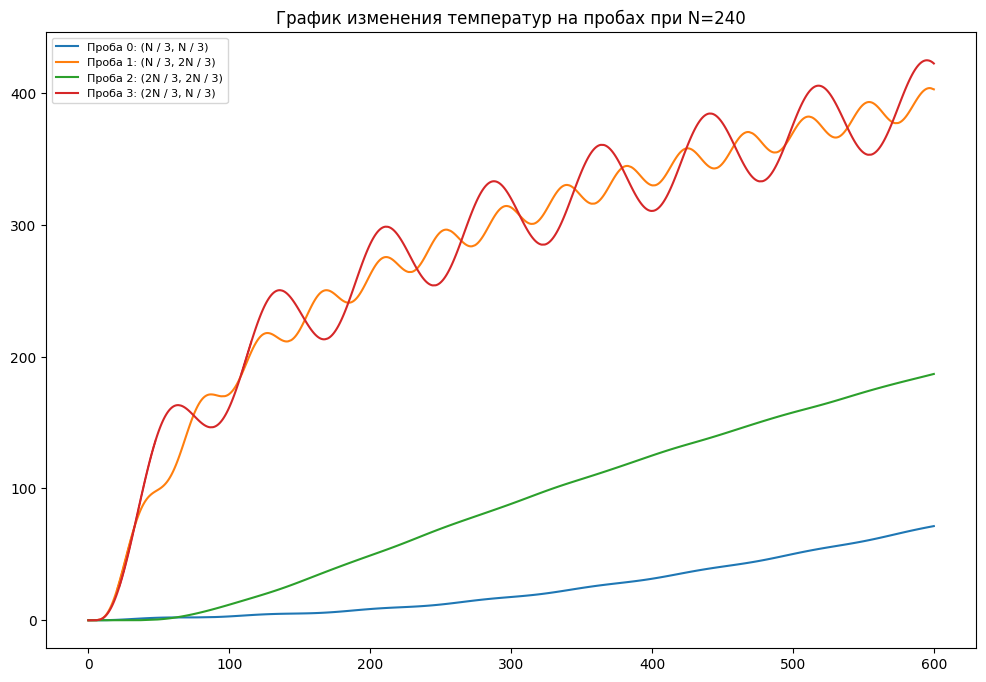

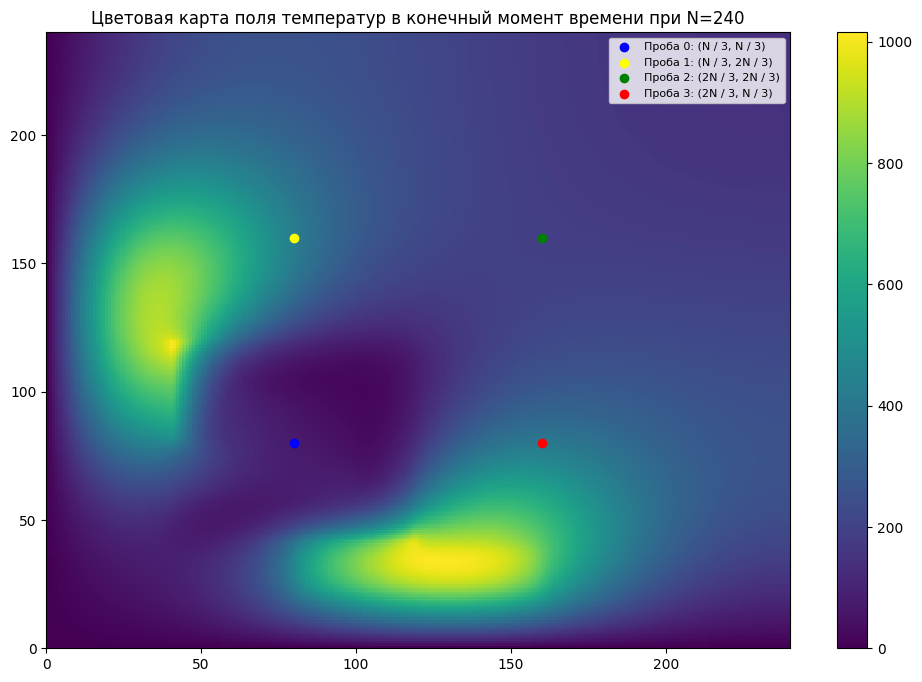

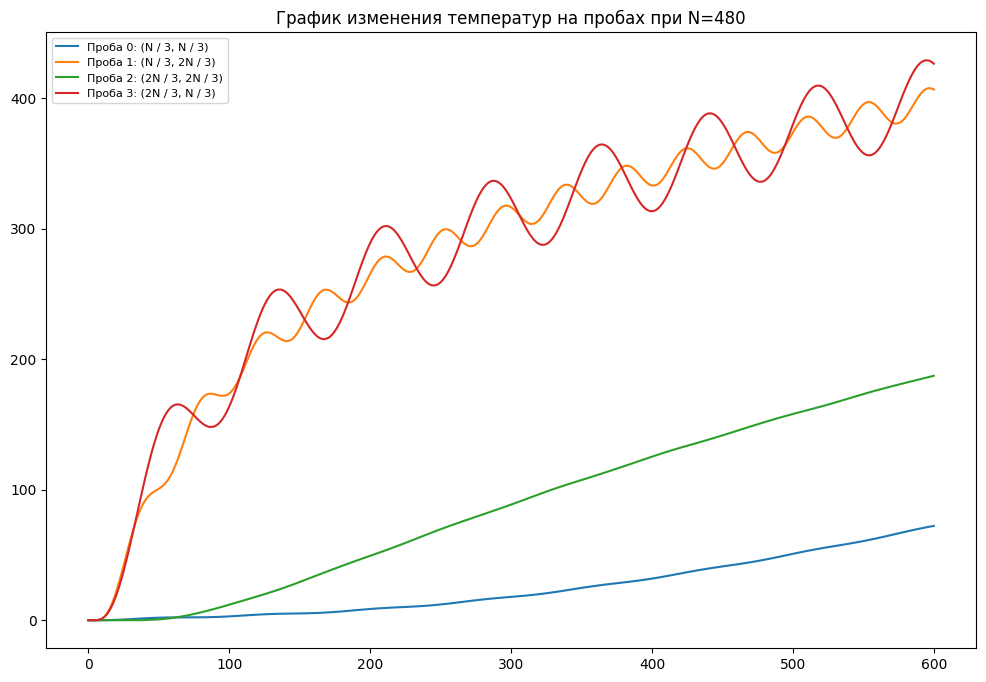

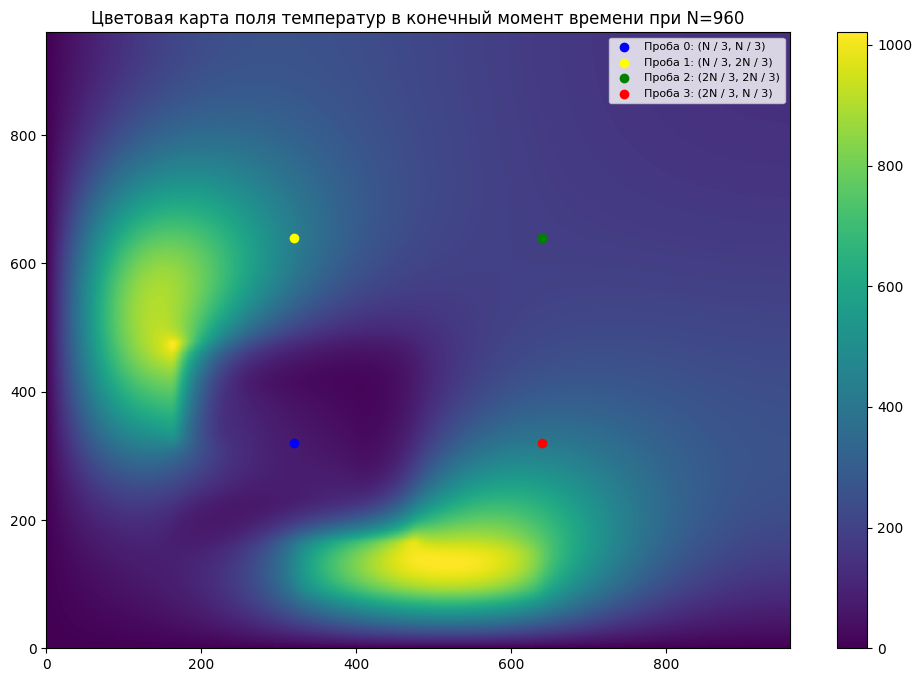

In [102]:
for N in [60,120, 240, 480, 960]:
    dx = 60 / N
    dt = C * dx**2 / D0
    max_iter = int(tmax / dt) #пересчитываем константы
    
    
    res0 = np.load('probe0_N_'+str(N)+'.npy') #загружаем файлы
    res1 = np.load('probe1_N_'+str(N)+'.npy')
    res2 = np.load('probe2_N_'+str(N)+'.npy')
    res3 = np.load('probe3_N_'+str(N)+'.npy')
    Tf = np.load('T_fin_N_' + str(N)+'.npy')
    plt.figure(figsize=(12,8))
    plt.plot(np.arange(max_iter)*dt, res0) #график изменения температур
    plt.plot(np.arange(max_iter)*dt, res1)
    plt.plot(np.arange(max_iter)*dt, res2)
    plt.plot(np.arange(max_iter)*dt, res3)
    plt.title("График изменения температур на пробах при N=" +str(N))
    plt.legend(['Проба 0: (N / 3, N / 3)',
                'Проба 1: (N / 3, 2N / 3)',
                'Проба 2: (2N / 3, 2N / 3)',
                'Проба 3: (2N / 3, N / 3)'], prop={'size': 8})
    plt.figure(figsize=(12,8))
    gg = plt.pcolormesh(Tf) #цветовая карта температур
    plt.scatter(x= N // 3, y= N // 3, label='Проба 0: (N / 3, N / 3)', color='blue')
    plt.scatter(x= N // 3, y= N * 2 // 3, label='Проба 1: (N / 3, 2N / 3)', color='yellow')
    plt.scatter(x= N * 2 // 3, y= N * 2 // 3, label='Проба 2: (2N / 3, 2N / 3)', color='green')
    plt.scatter(x= N * 2 // 3, y= N // 3, label='Проба 3: (2N / 3, N / 3)', color='red')
    plt.title("Цветовая карта поля температур в конечный момент времени при N=" +str(N))
    plt.legend(prop={'size': 8})
    plt.colorbar(gg)

In [86]:
def fperiods(res, dt):
    """fperiods(res, dt):
        -res - данные, для которых ищем периоды
        -dt - приращение времени
        Функция находит периоды колебаний набора данных с помощью быстрого преобразования Фурье"""
    size, res_mean = res.size, res.mean()
    r = np.fft.rfft(res - res_mean)
    amp = (np.abs(r) / (size / 2))[:50]
    frequency = np.fft.rfftfreq(size, dt)[:50]
    peaks, _ = signal.find_peaks(amp)
    return 1 / frequency[peaks]

Периоды колебания температуры на каждой пробе:

In [87]:
for N in [60, 120, 240, 480, 960]:
    for i in range(4):
        res_file = np.load('probe'+str(i)+'_N_'+str(N)+'.npy')
        ys = res_file
        xs = np.arange(len(ys))
        coeff = np.polyfit(xs, ys, deg=4)
        ps = np.poly1d(coeff)(xs)
        p_fin = ys - ps
        periods = fperiods(p_fin, dt)
        print(f'Периоды пробы {i} при N={N}:',  periods)

Периоды пробы 0 при N=60: [1.171875   0.29296875]
Периоды пробы 1 при N=60: [1.171875   0.46875    0.16741071]
Периоды пробы 2 при N=60: [1.171875   0.5859375  0.29296875 0.15625   ]
Периоды пробы 3 при N=60: [1.171875   0.29296875]
Периоды пробы 0 при N=120: [4.6875   1.171875]
Периоды пробы 1 при N=120: [4.6875     1.875      0.66964286]
Периоды пробы 2 при N=120: [4.6875   2.34375  1.171875 0.625   ]
Периоды пробы 3 при N=120: [4.6875   1.171875]
Периоды пробы 0 при N=240: [18.75    4.6875]
Периоды пробы 1 при N=240: [18.75        7.5         2.67857143]
Периоды пробы 2 при N=240: [18.75    9.375   4.6875  2.5   ]
Периоды пробы 3 при N=240: [18.75    4.6875]
Периоды пробы 0 при N=480: [75.   18.75]
Периоды пробы 1 при N=480: [75.         30.         10.71428571]
Периоды пробы 2 при N=480: [75.   37.5  18.75 10.  ]
Периоды пробы 3 при N=480: [75.   18.75]
Периоды пробы 0 при N=960: [300.  75.]
Периоды пробы 1 при N=960: [300.         120.          42.85714286]
Периоды пробы 2 при N=9